In [40]:
% reset
% config InlineBackend.figure_format = 'retina'

import numpy as np
import scipy as sp
import statsmodels.api as sm
from scipy.stats import mode
from scipy import signal

import h5py

from scipy.optimize import curve_fit

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import foof_utils as fu

% matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 12
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [41]:
# load the data and pick a channel
chandat = np.loadtxt("ecog_data.csv", delimiter=",")
chandat = chandat[:, 0]

[]

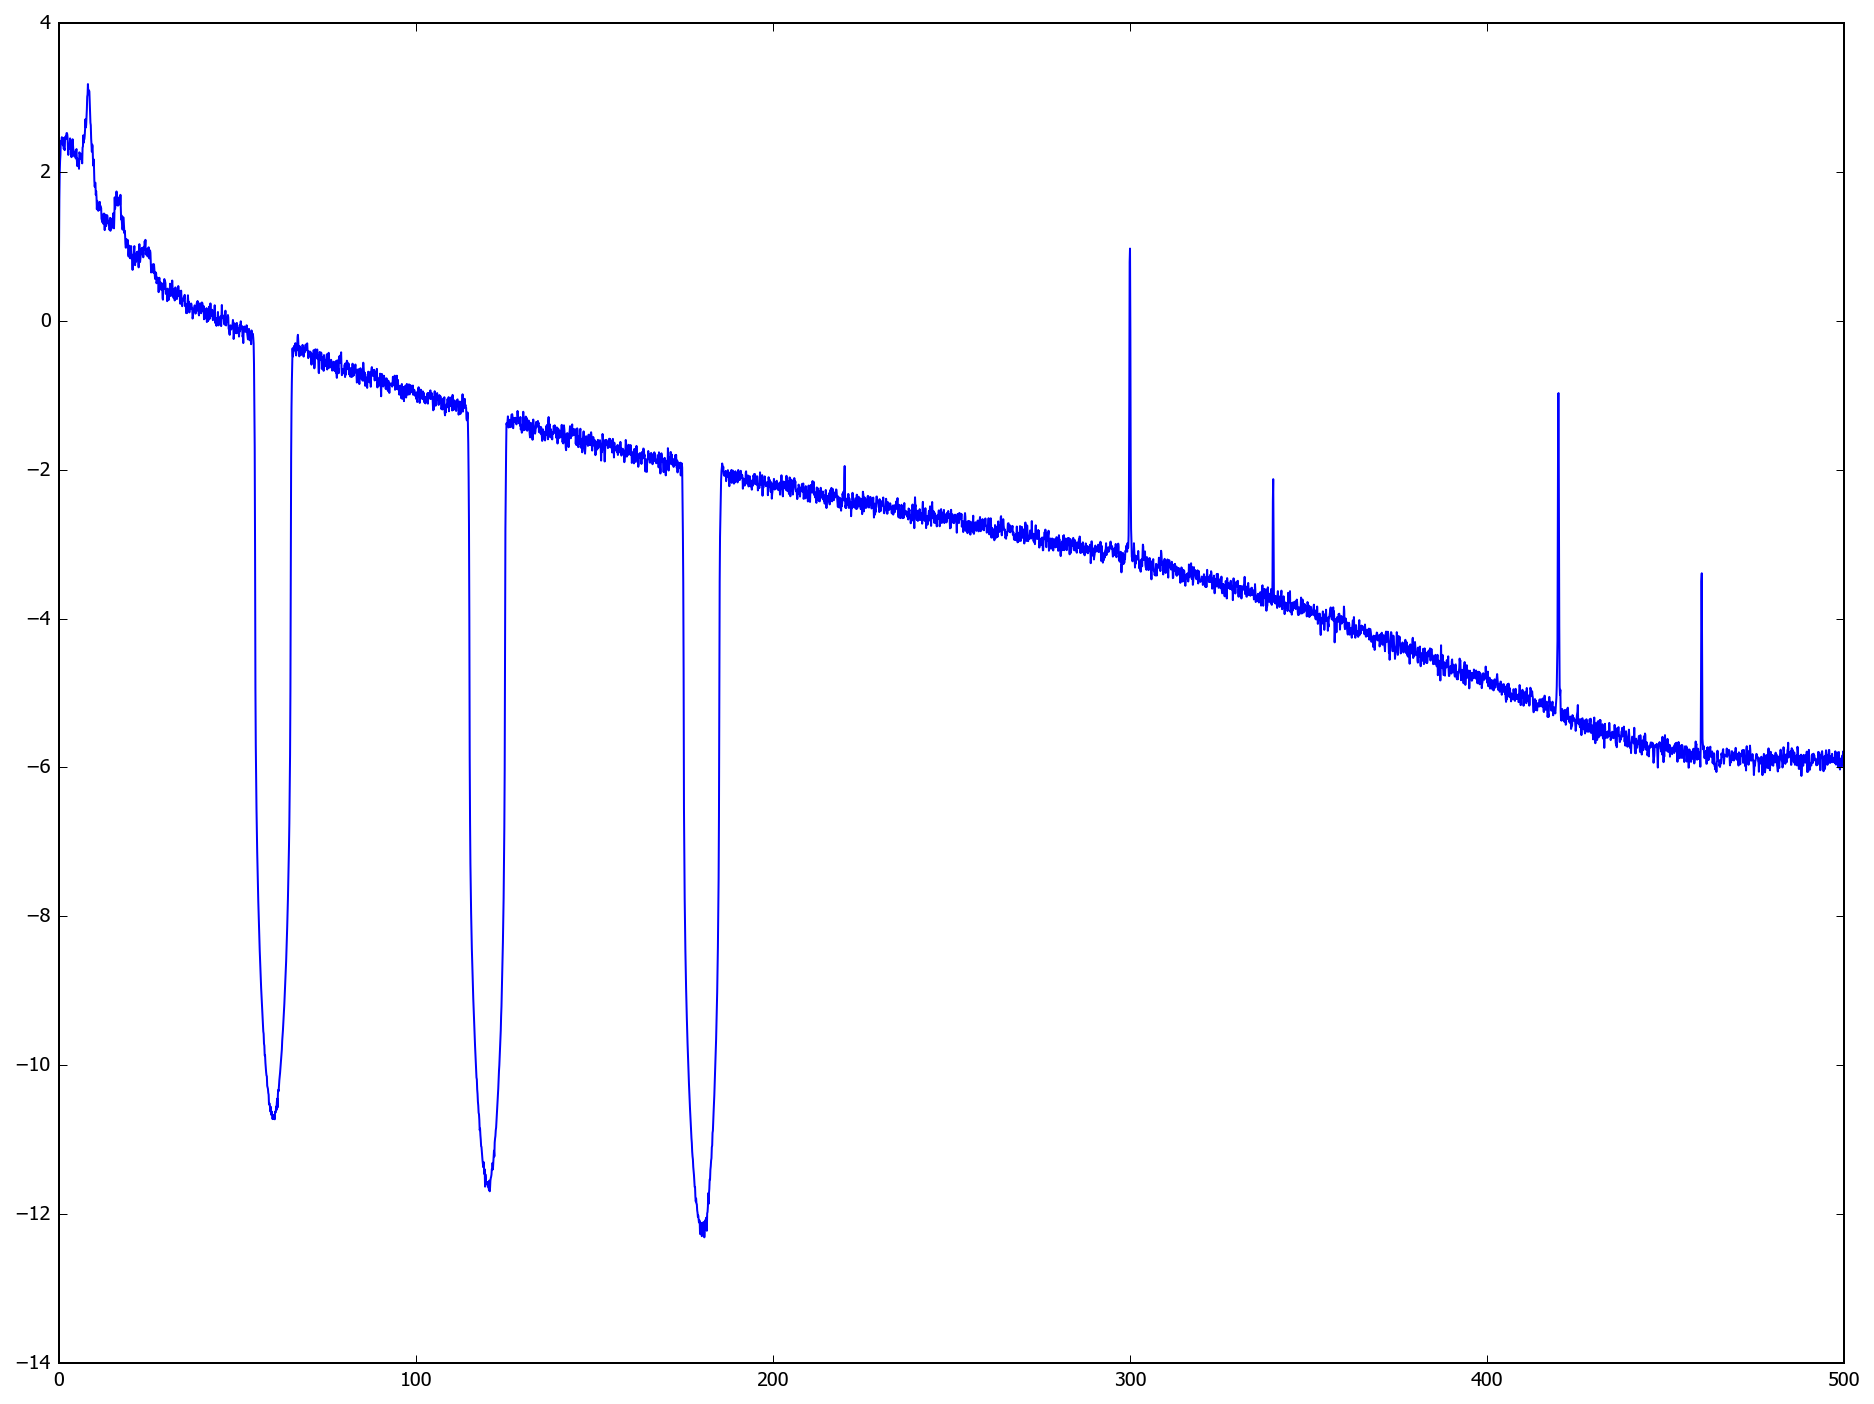

In [42]:
# make the PSD

srate = 1000.0
window_size = int(srate*10)
overlap = int(window_size * 0.5)

xf, _, psd_array = signal.spectrogram(chandat, fs=srate, window=('hanning'), nperseg=window_size, noverlap=overlap)
psd_array = np.log10(psd_array)

plt.plot(xf, np.mean(psd_array, 1))
plt.plot()


In [223]:
# simulate spectrum

frequency_vector = np.linspace(2, 35, 1000)
slope_params = [5.11, -0.0567, 0.00059]
oscillation_params = [[0.53, 7.98, 1.7],[0.33, 12.3, 2.3],[0.13, 23.1, 3.3]]
noise = [0.0, 0.025]

res = mode(np.diff(frequency_vector))[0]

number_of_samples = 100

foof_spec = fu.simulate_neural_spectra(frequency_vector, slope_params, oscillation_params, noise)

for i in range(number_of_samples-1):
    simulated_spectrum = fu.simulate_neural_spectra(frequency_vector, slope_params, oscillation_params, noise)
    foof_spec = np.vstack((foof_spec, simulated_spectrum))  


In [224]:
# split data into training/test sets

spec_train, spec_test = train_test_split(foof_spec, test_size=0.5)

train_data = np.mean(spec_train,0)
test_data = np.mean(spec_test,0)

train_data = train_data + np.random.normal(0, 0.05, np.size(train_data))


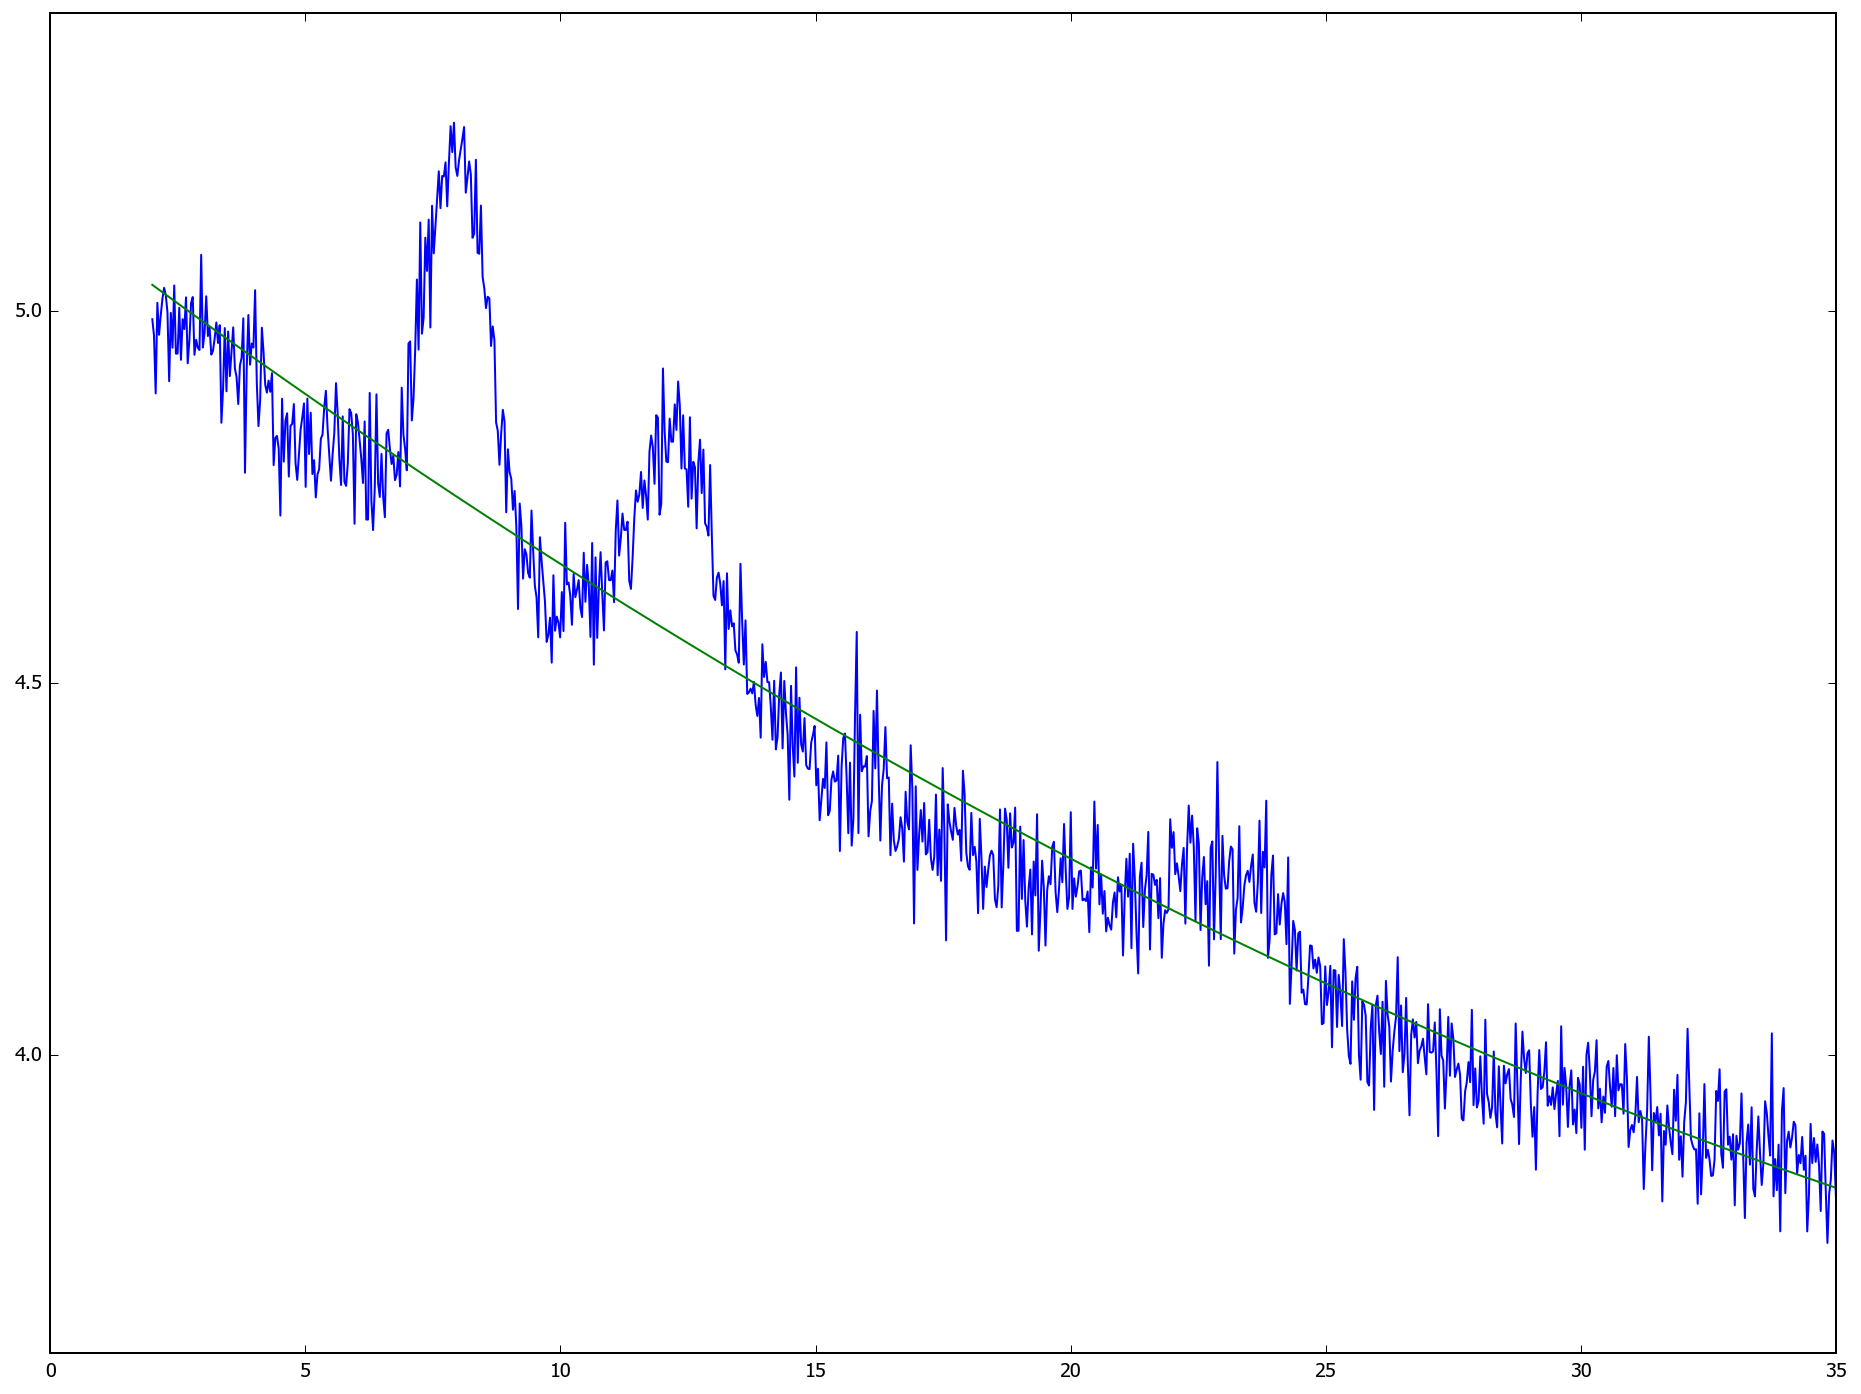

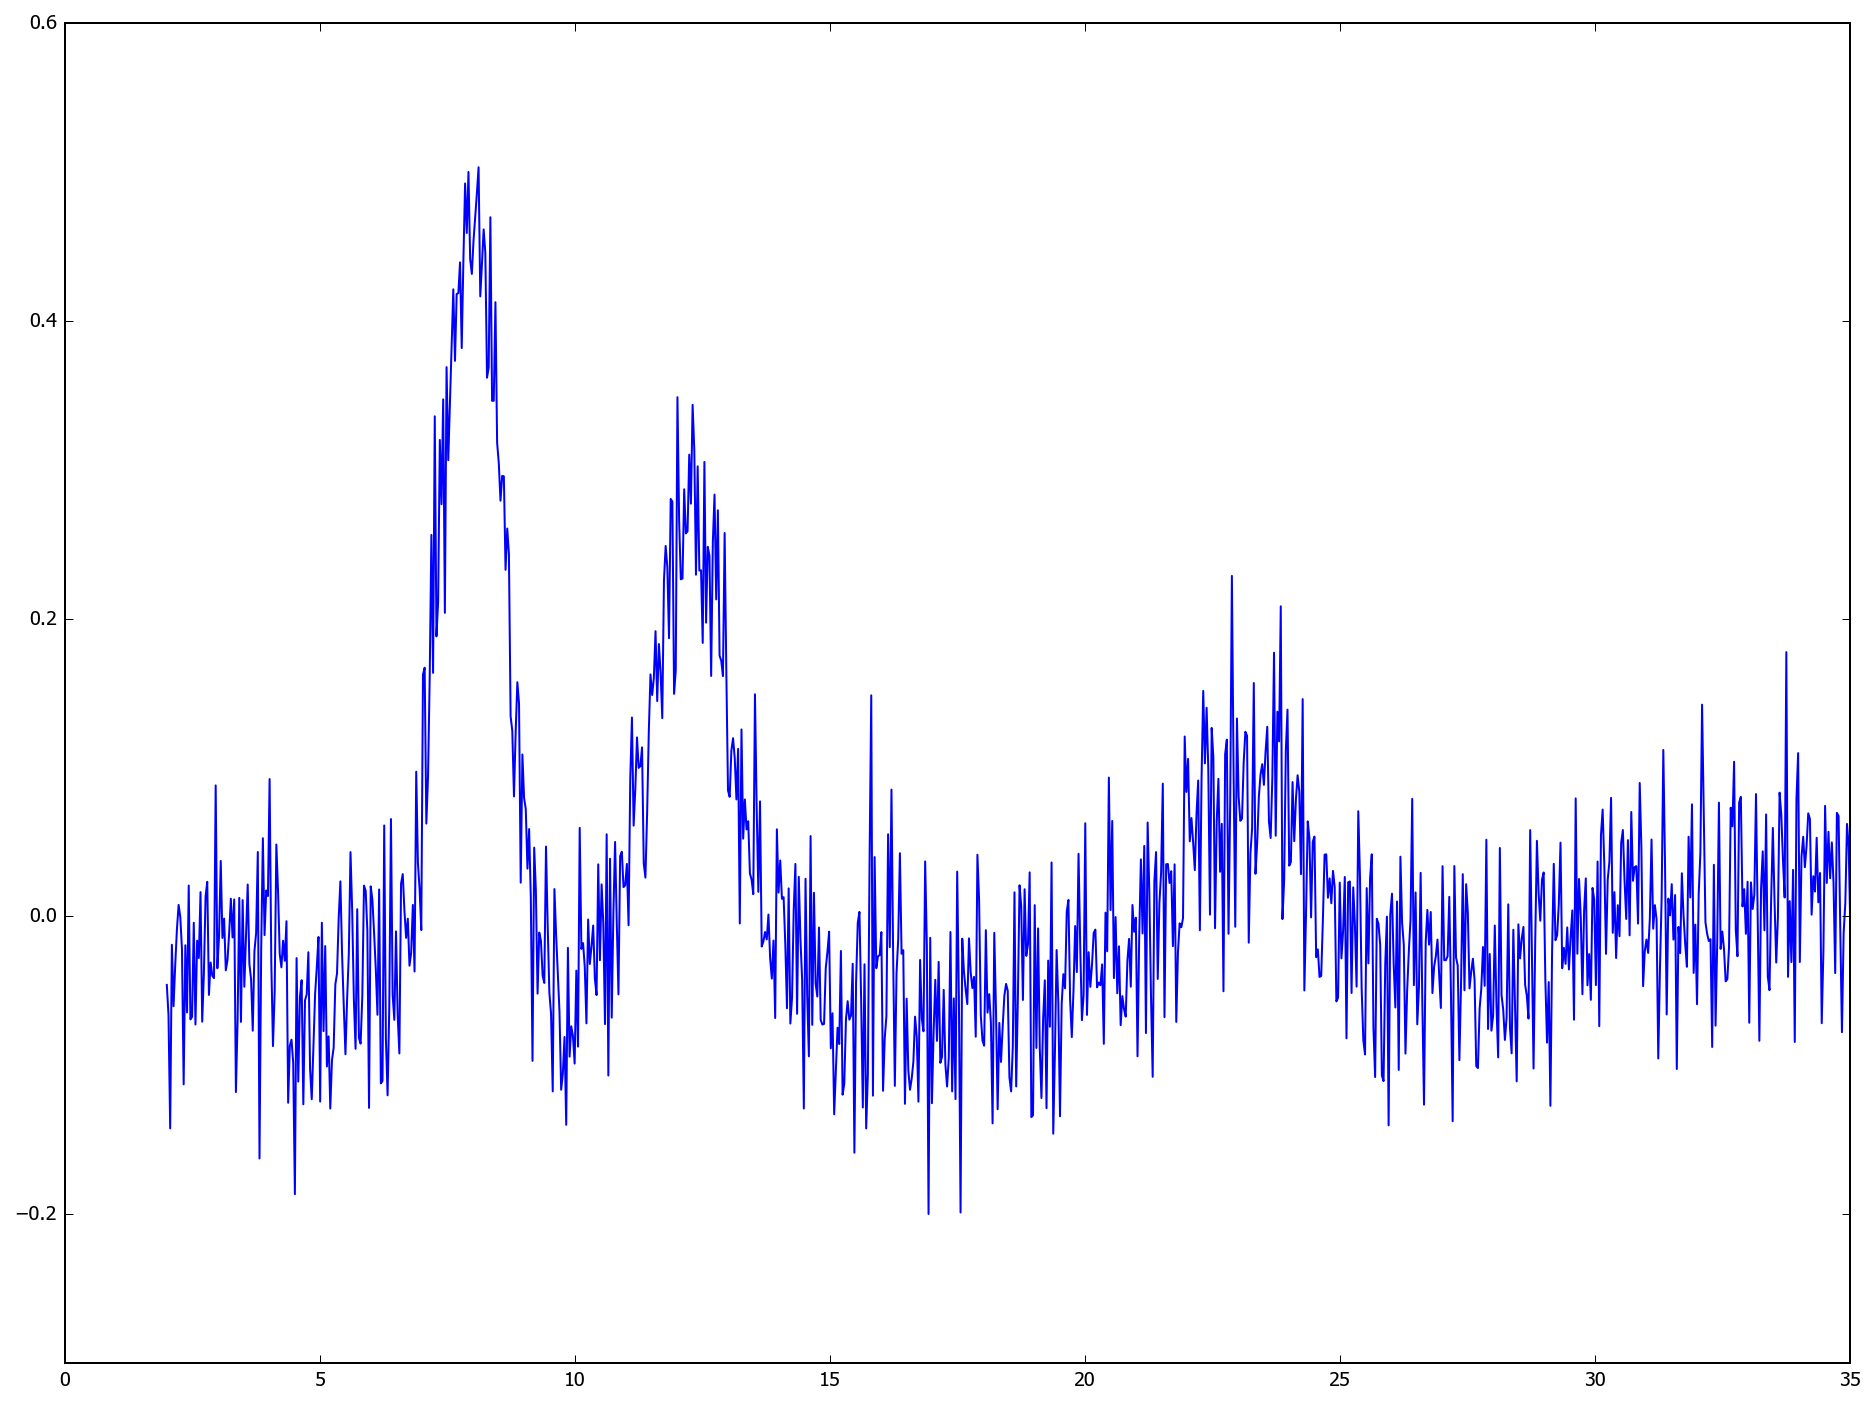

In [225]:
Xvar = np.column_stack((frequency_vector, frequency_vector**2))
Xvar = sm.add_constant(Xvar)

mdl_fit = sm.RLM(train_data, Xvar, M=sm.robust.norms.HuberT()).fit()
# print(mdl_fit.summary())
# print(mdl_fit.params)

plt.plot(frequency_vector, train_data)
plt.plot(frequency_vector, mdl_fit.fittedvalues)
plt.show()

p_flat = train_data - mdl_fit.fittedvalues
plt.plot(frequency_vector, p_flat)
plt.show()

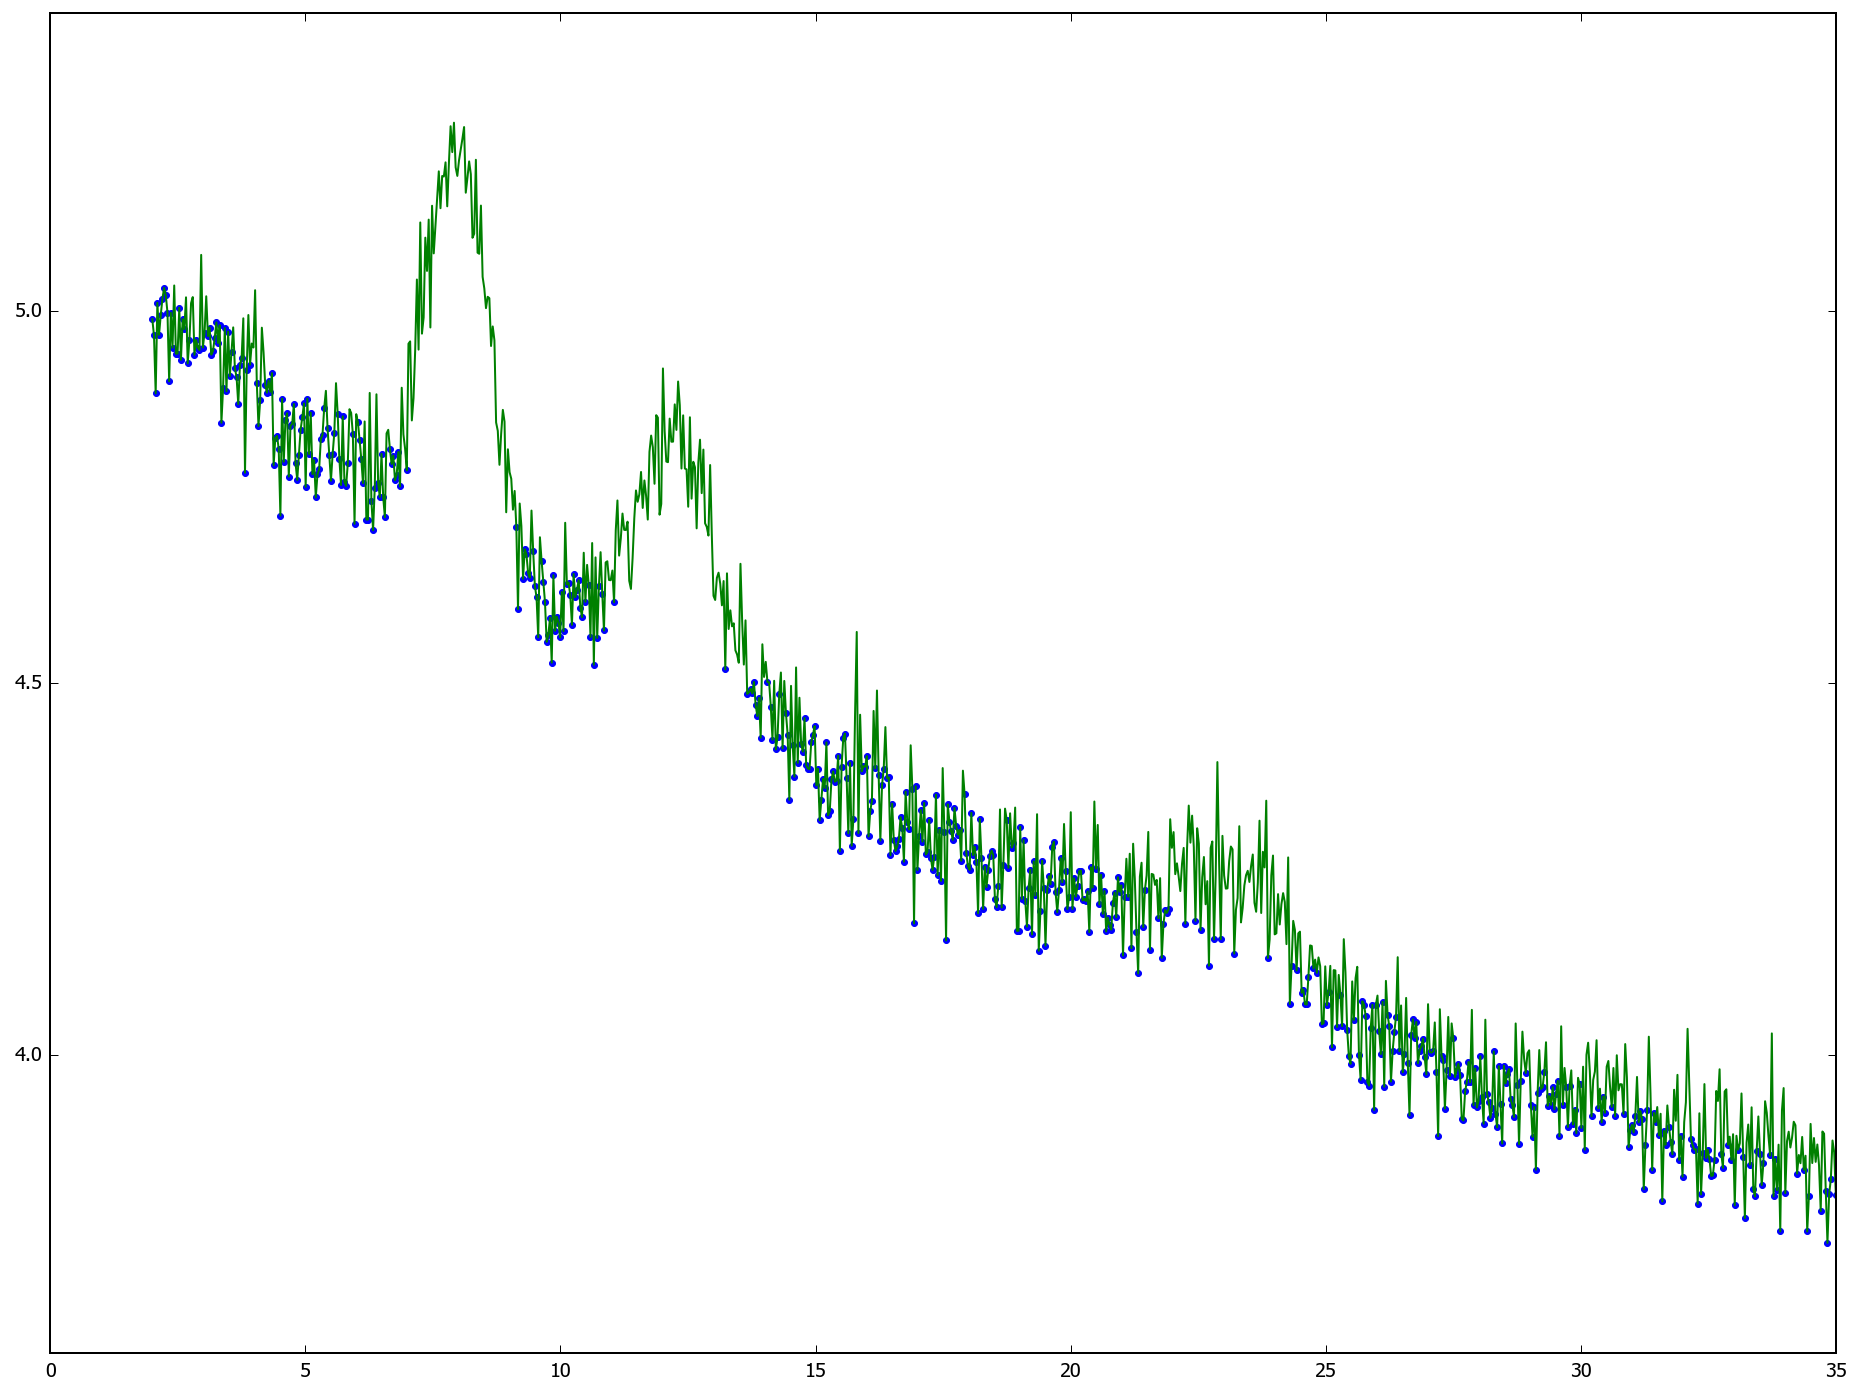

In [226]:
p_flat[p_flat<0] = 0
cutoff = p_flat<=(np.max(p_flat)*0.025)

f_ignore = frequency_vector[cutoff]
p_ignore = train_data[cutoff]

plt.plot(f_ignore, p_ignore, '.')
plt.plot(frequency_vector, train_data)
plt.show()


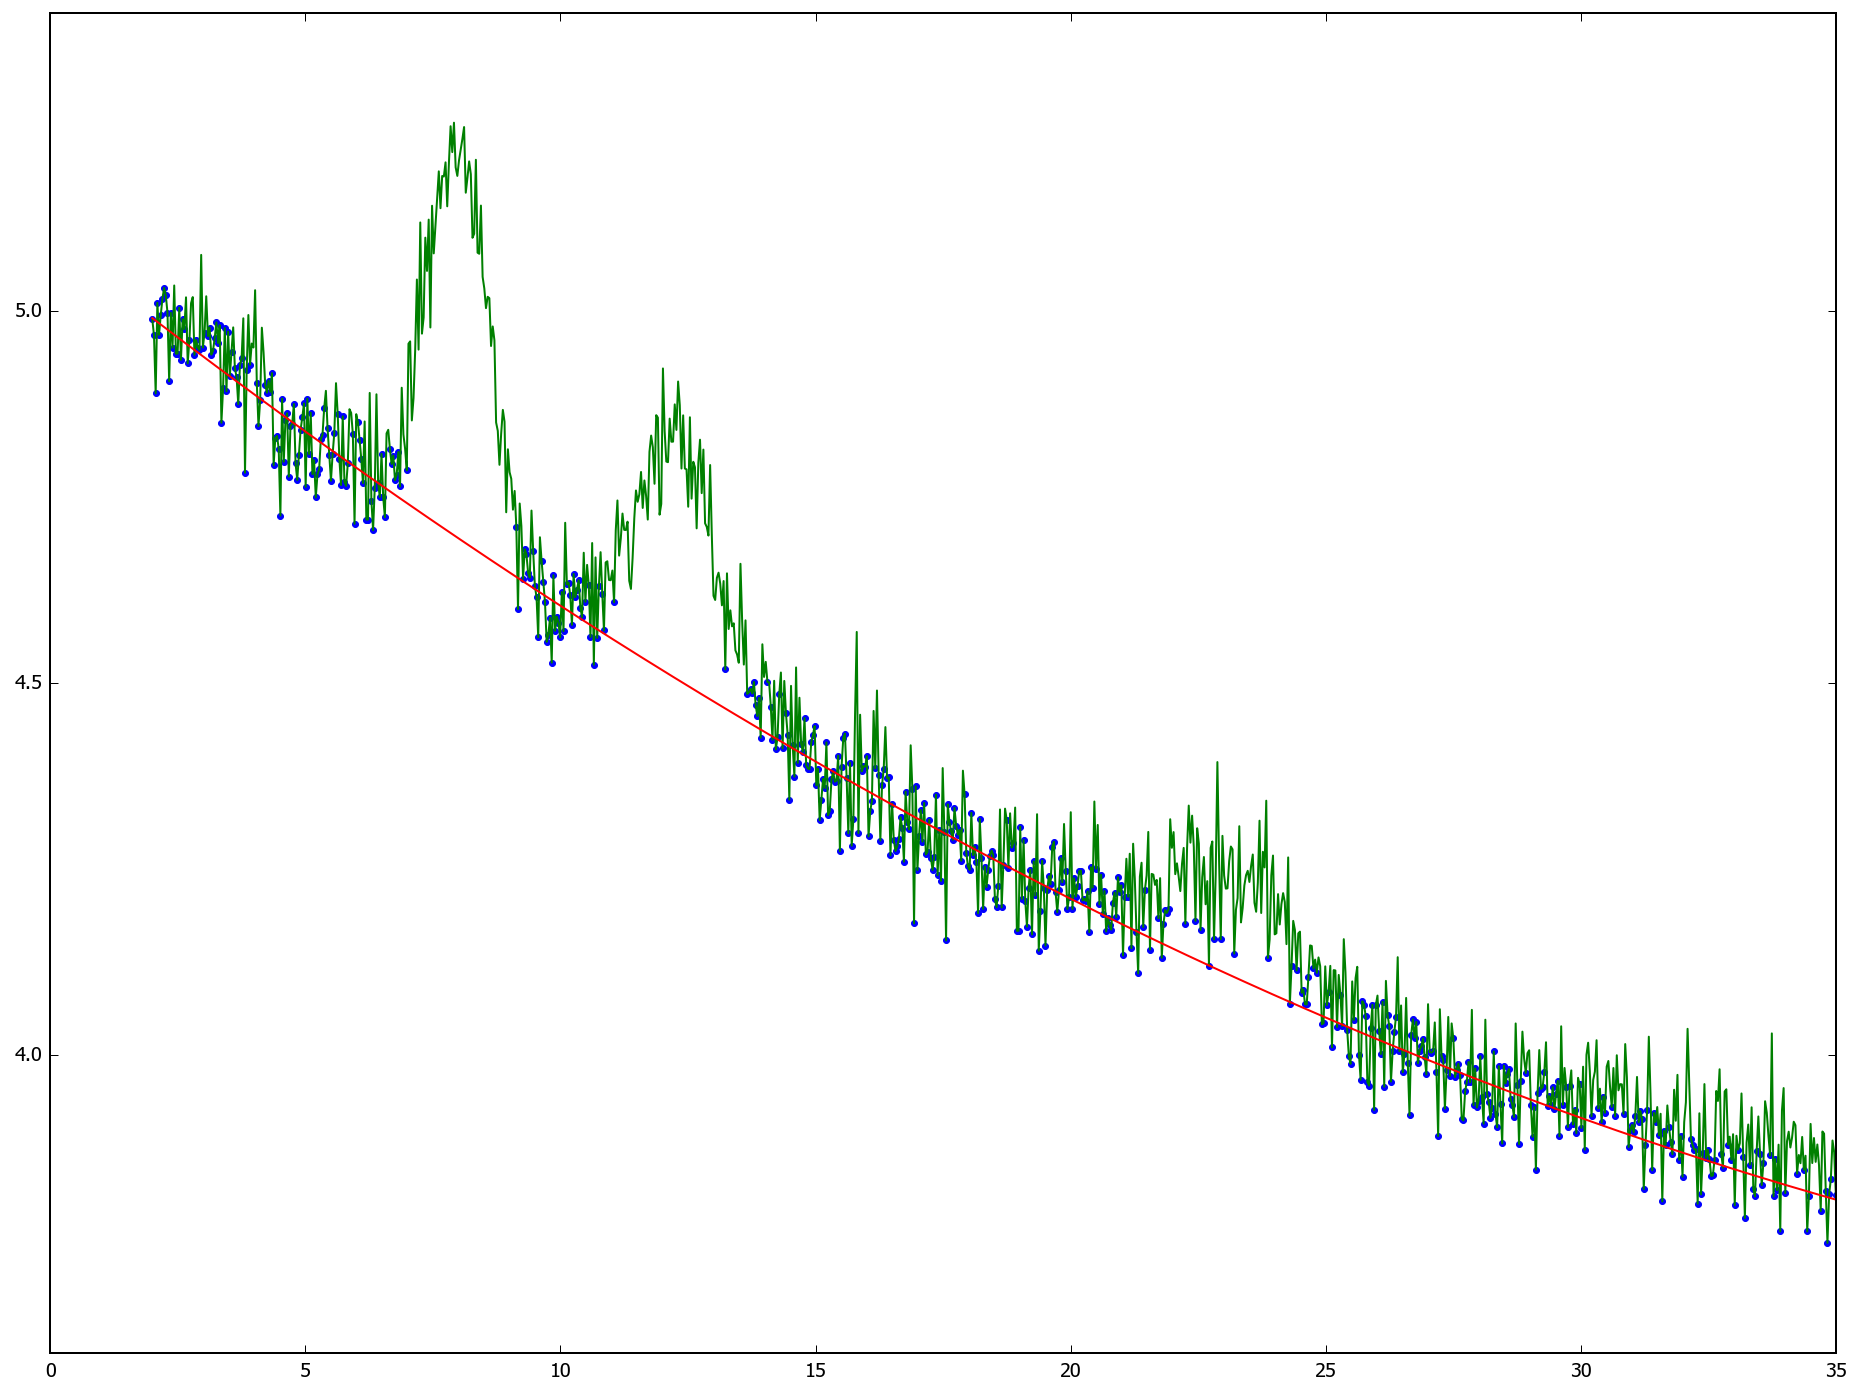

[  4.97078504e-04  -5.42958734e-02   5.09706650e+00]
[5.11, -0.0567, 0.00059]


In [227]:
p_params = np.polyfit(f_ignore, p_ignore, 2)
p_fit = np.poly1d(p_params)

plt.plot(f_ignore, p_ignore, '.')
plt.plot(frequency_vector, train_data)
plt.plot(frequency_vector, p_fit(frequency_vector))
plt.show()

p_flat_real = train_data - p_fit(frequency_vector)
p_flat_real[p_flat_real<0] = 0

print(p_params)
print(slope_params)


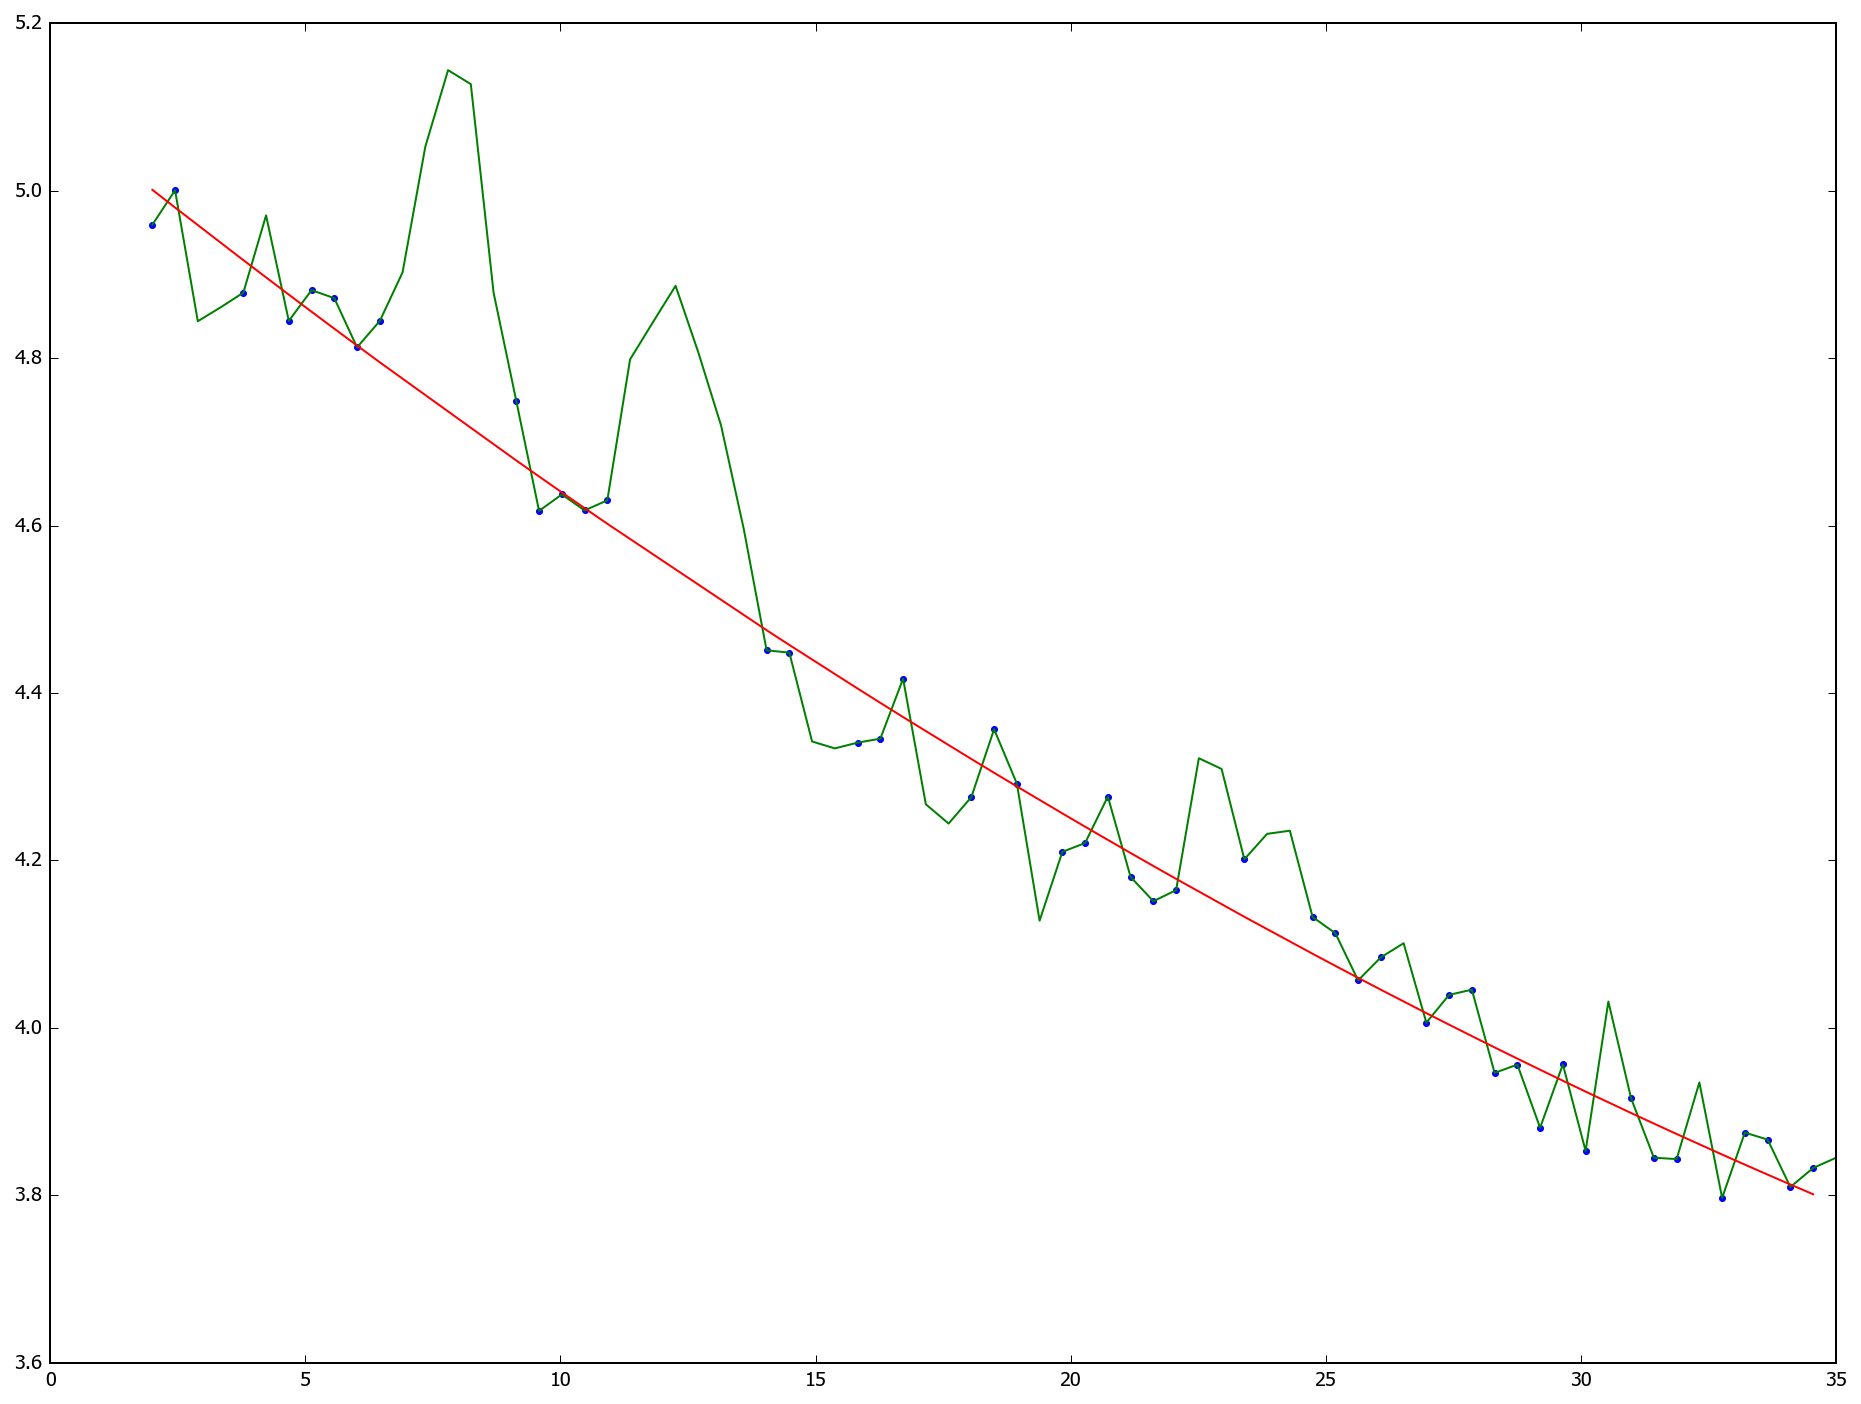

In [158]:
Xvar = np.column_stack((f_ignore, f_ignore**2))
Xvar = sm.add_constant(Xvar)

mdl_fit = sm.RLM(p_ignore, Xvar, M=sm.robust.norms.HuberT()).fit()
# print(mdl_fit.summary())
# print(mdl_fit.params)
# print(slope_params)

background_fit = mdl_fit.params[0] + (mdl_fit.params[1]*(frequency_vector)) + (mdl_fit.params[2]*(frequency_vector**2))
p_flat_real = train_data - background_fit
p_flat_real[p_flat_real<0] = 0
# plt.plot(frequency_vector, p_flat_real)
# plt.show()


plt.plot(f_ignore, p_ignore, '.')
plt.plot(frequency_vector, train_data)
plt.plot(f_ignore, mdl_fit.fittedvalues)
plt.show()


[ 7.90902981  0.43580008  0.89595163]


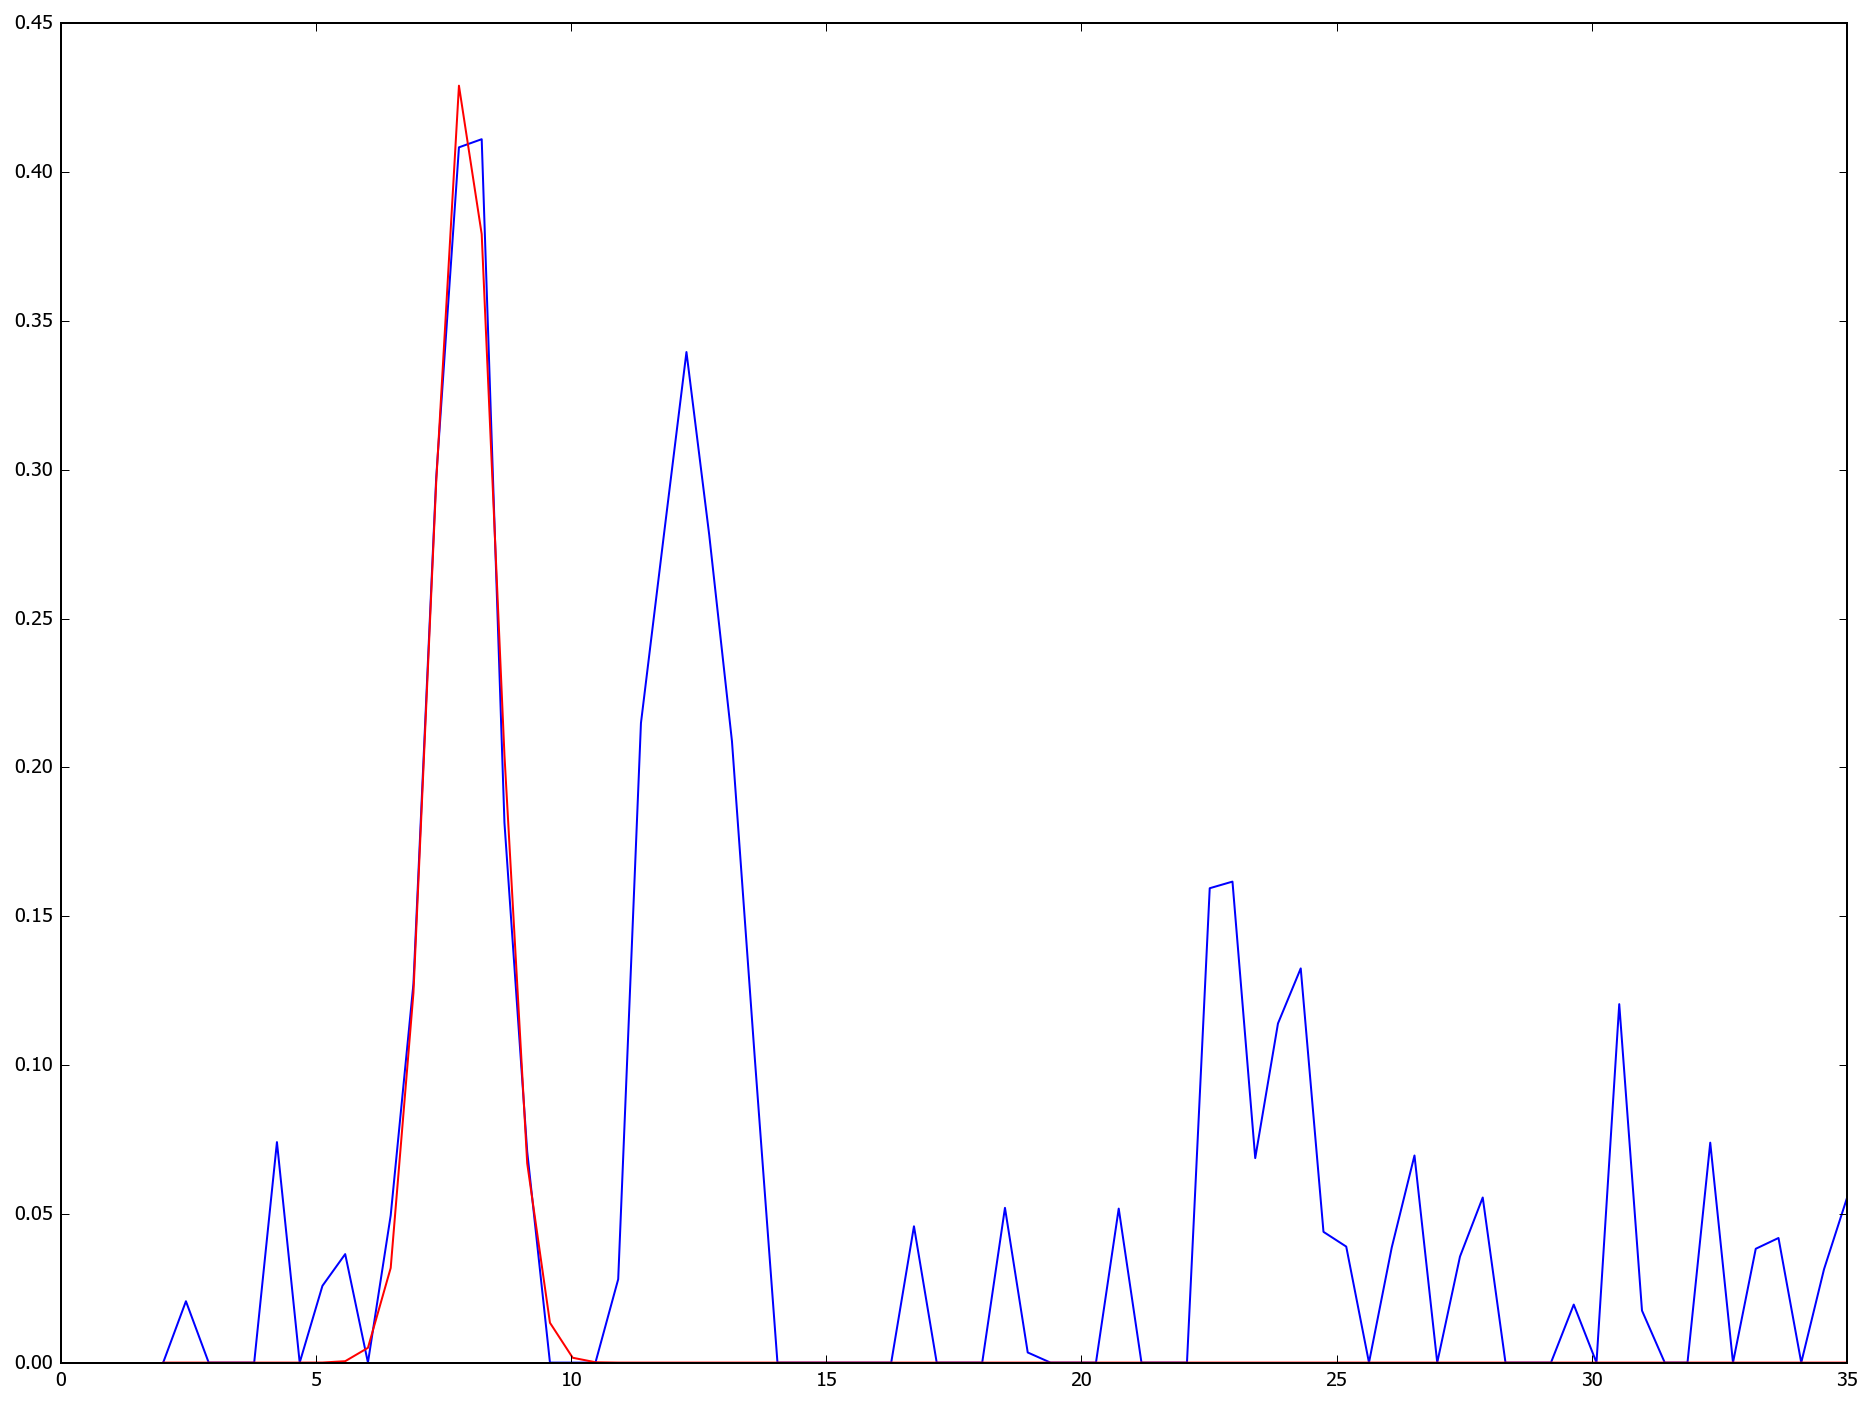

In [159]:
def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

max_index = np.argmax(p_flat_real)
guess_freq = frequency_vector[max_index]

window_around_max = 4 # in Hz
window_around_max = np.floor(4/res)
window_around_max = int(window_around_max[0])

p_flat_zeros = p_flat_real - 0
p_flat_zeros[0:(max_index-window_around_max)] = 0
p_flat_zeros[(max_index+window_around_max):,] = 0

guess = [guess_freq, np.max(p_flat_zeros), 3]
guess = np.array(guess)

popt, pcov = curve_fit(func, frequency_vector, p_flat_zeros, p0=guess)
print(popt)
fit = func(frequency_vector, *popt)
fit = np.array(fit)

p_flat_iteration = p_flat_real - fit

plt.plot(frequency_vector, p_flat_real)
plt.plot(frequency_vector, fit, 'r-')
plt.show()

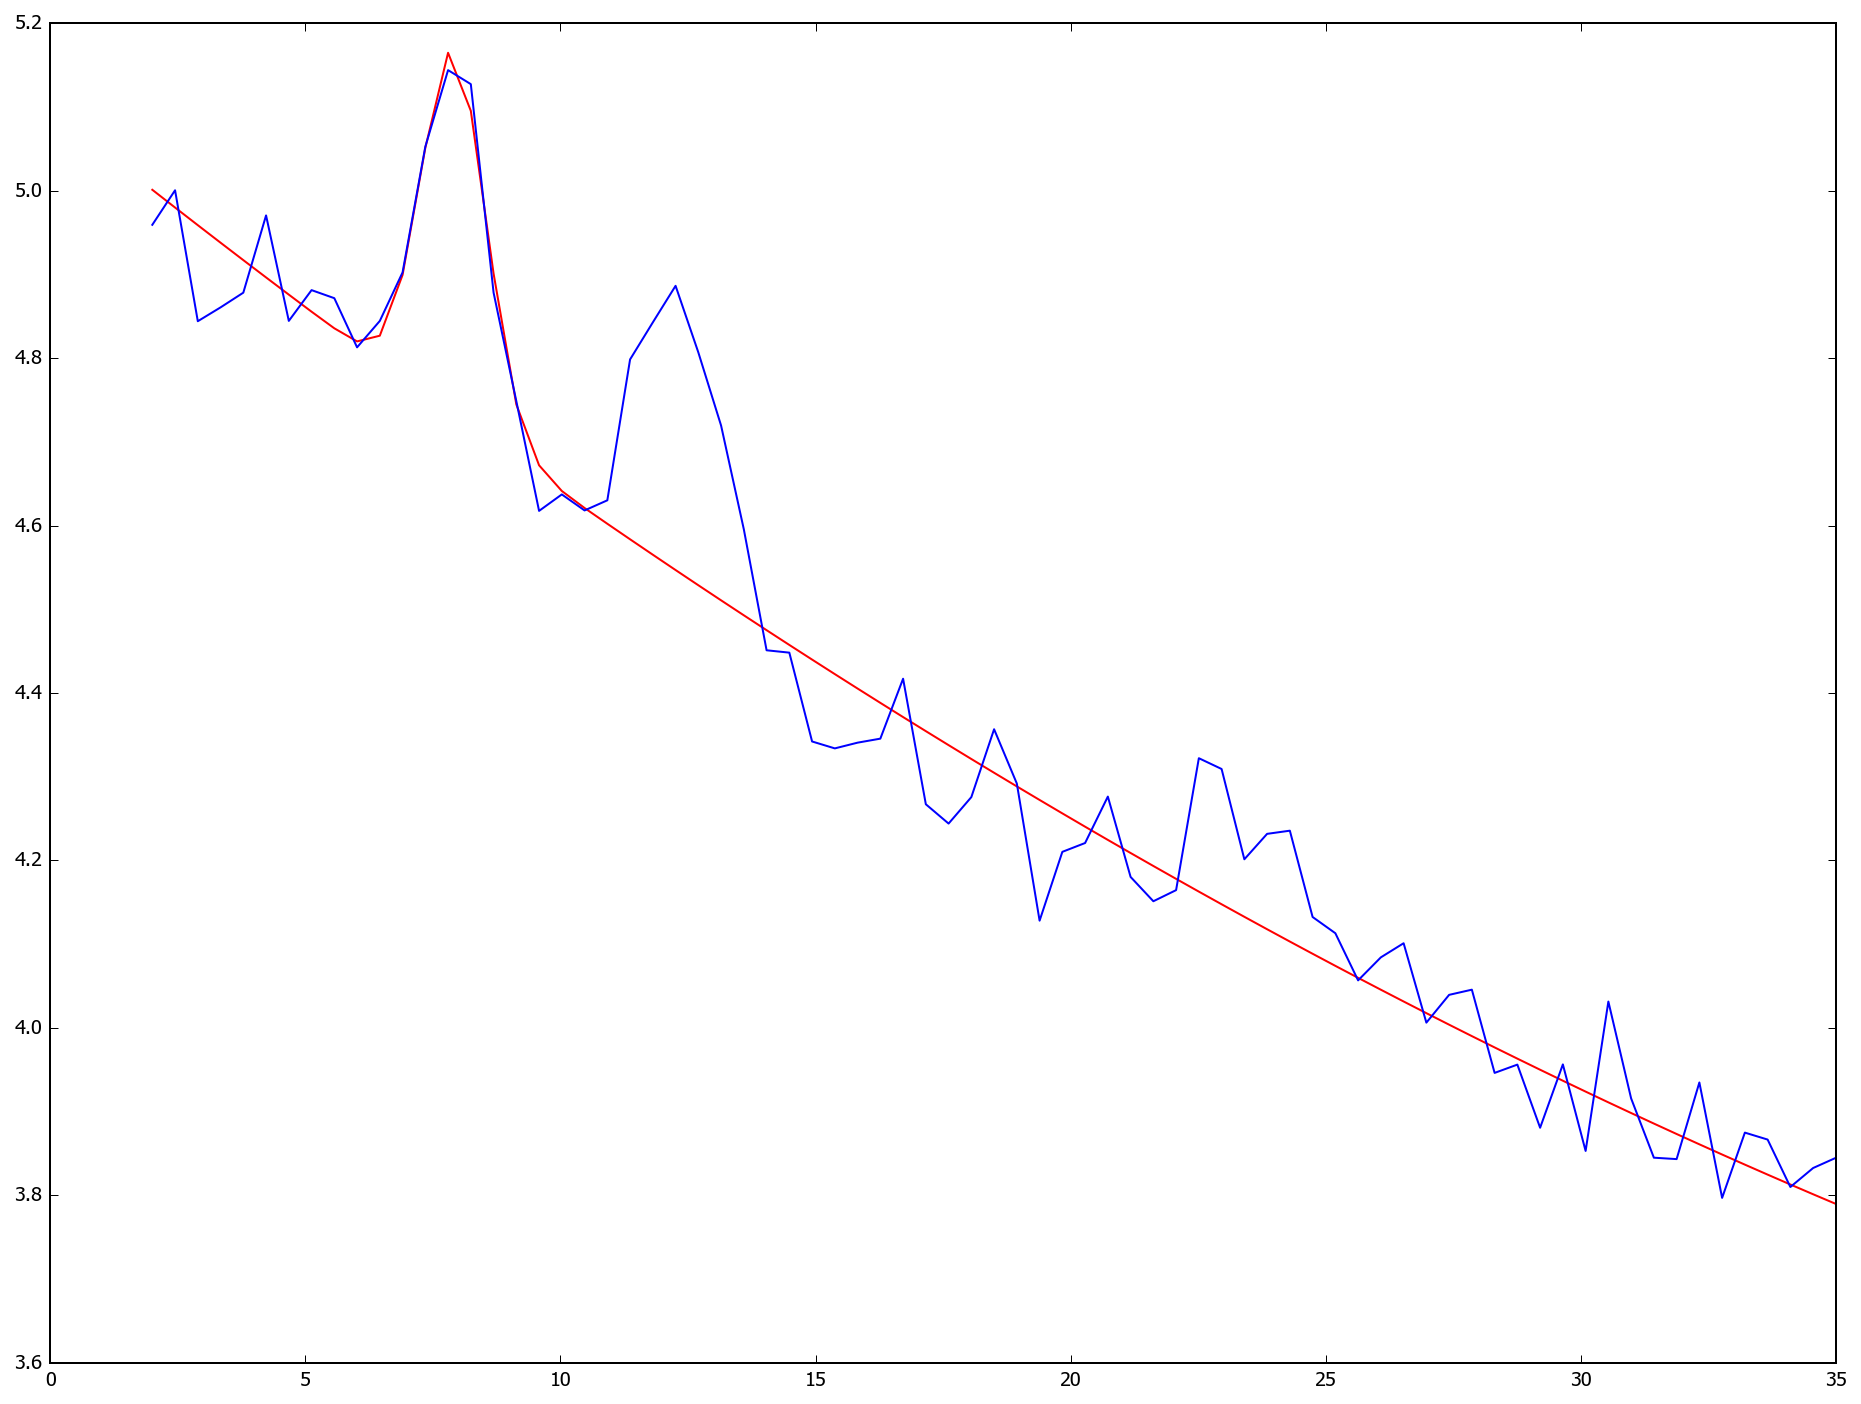

In [160]:
plt.plot(frequency_vector, fit+background_fit, 'r-')
plt.plot(frequency_vector, train_data)
plt.show()


In [161]:
rms = np.ndarray(0)
rms = np.append(rms, np.sqrt(mean_squared_error(test_data, fit+background_fit)))
print(rms)

[ 0.06799771]


[ 31.11317416   0.03146129   3.4133758 ]


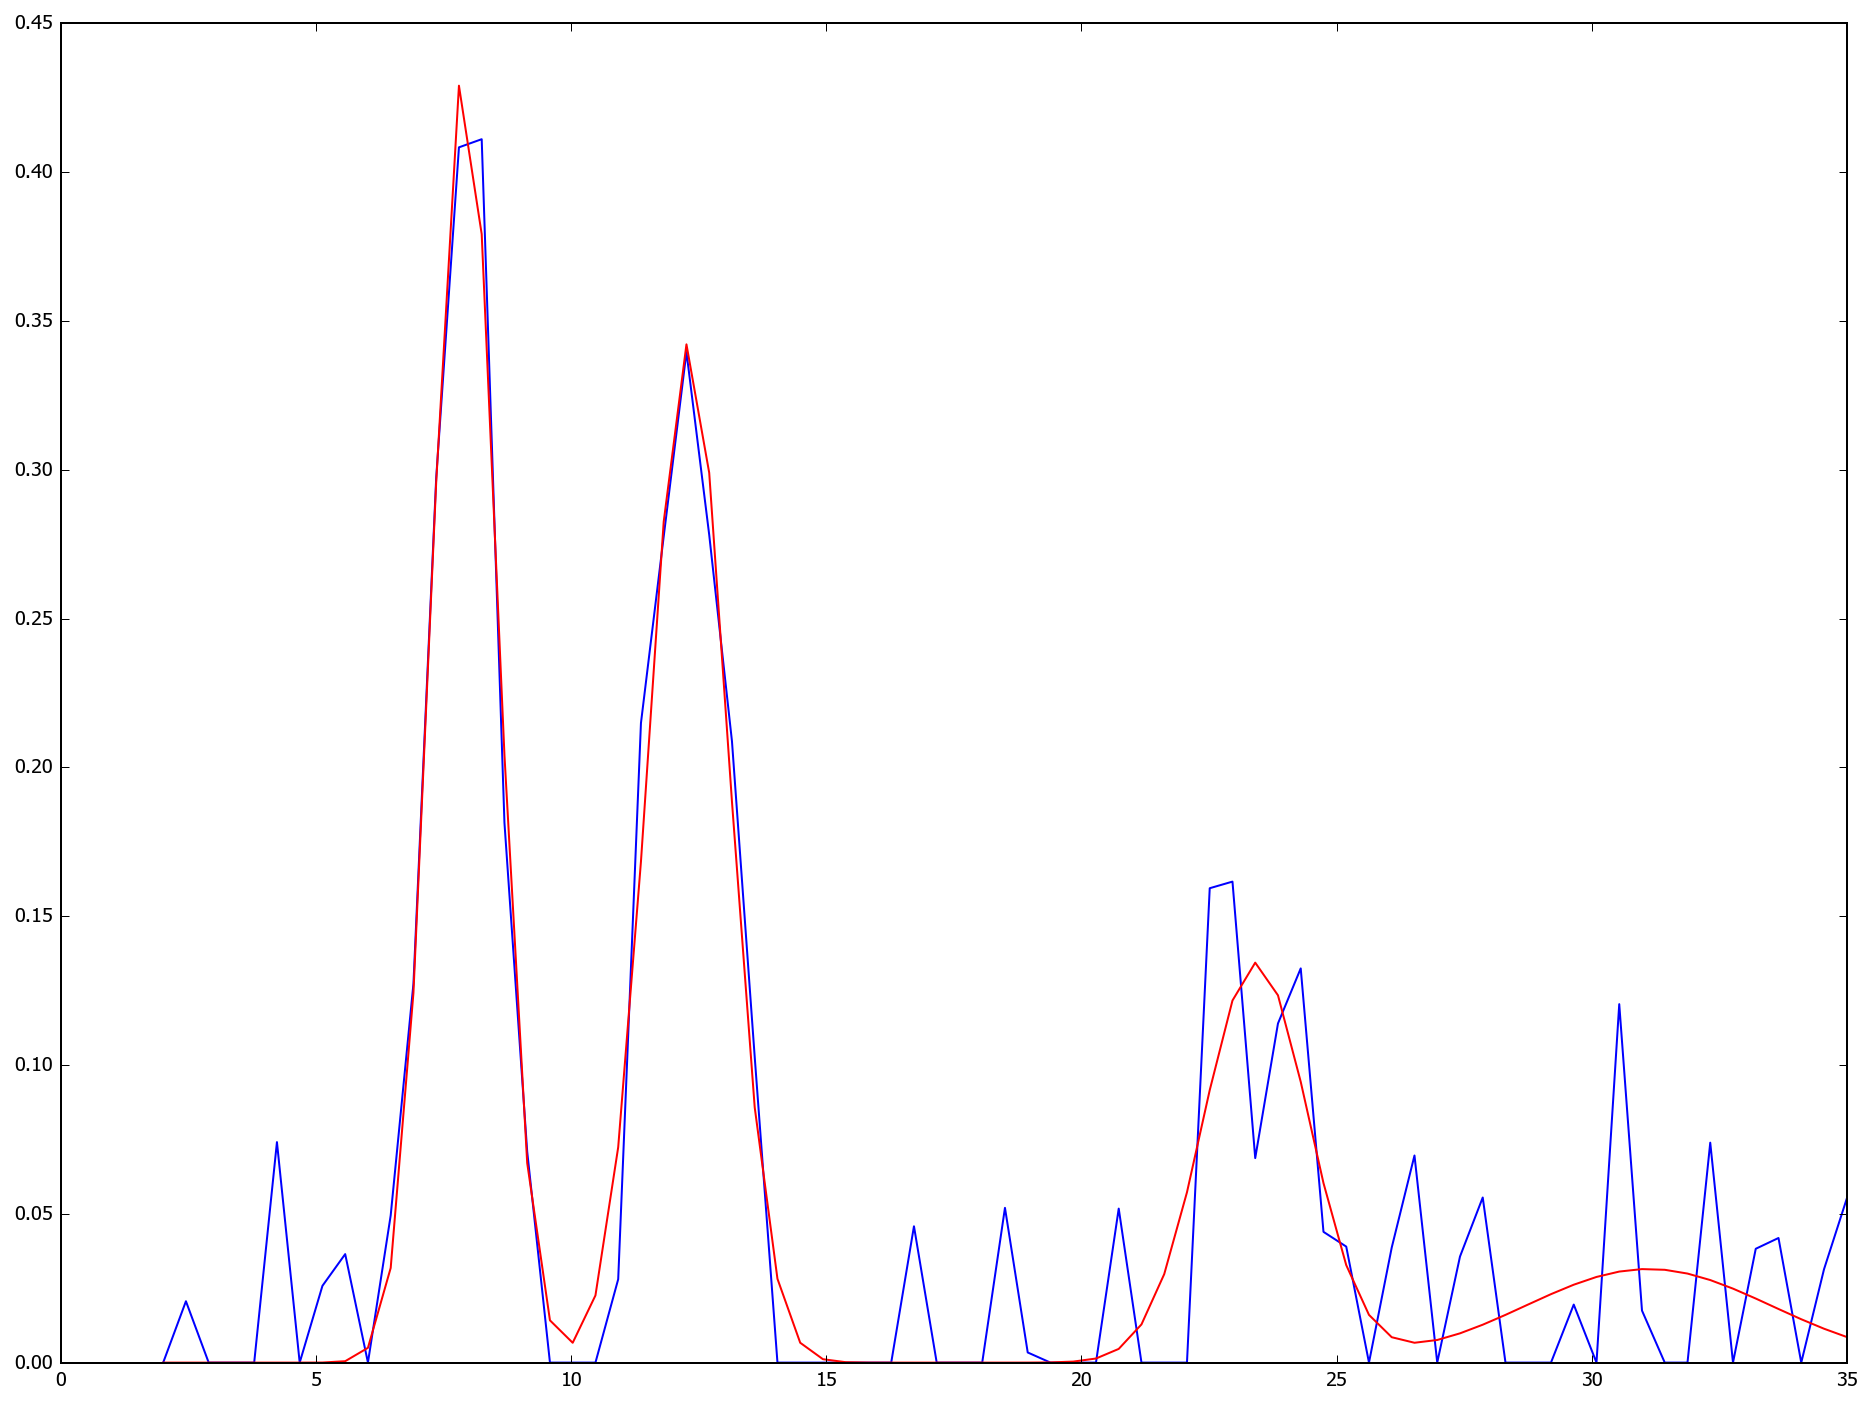

[ 0.06799771  0.03957228  0.03308002  0.03143881]


In [164]:
max_index = np.argmax(p_flat_iteration)
guess_freq = frequency_vector[max_index]

window_around_max = 4 # in Hz
window_around_max = np.floor(4/res)
window_around_max = int(window_around_max[0])

p_flat_zeros = p_flat_iteration
p_flat_zeros[0:(max_index-window_around_max)] = 0
p_flat_zeros[(max_index+window_around_max):,] = 0

guess = [guess_freq, np.max(p_flat_zeros), 3]
guess = np.array(guess)

popt, pcov = curve_fit(func, frequency_vector, p_flat_iteration, p0=guess, maxfev=5000)
print(popt)
fit = np.vstack((fit, func(frequency_vector, *popt)))

plt.plot(frequency_vector, p_flat_real)
plt.plot(frequency_vector, np.sum(fit,0), 'r-')
plt.show()

p_flat_iteration = p_flat_real - np.sum(fit,0)

rms = np.append(rms, np.sqrt(mean_squared_error(test_data, np.sum(fit,0)+background_fit)))
print(rms)


In [169]:
popt, np.var(p_flat_real)/np.mean(p_flat_real)

(array([ 31.11317416,   0.03146129,   3.4133758 ]), 0.15382606262142359)

In [132]:
fu.std_to_bw(popt[2])

8.4852813742385713

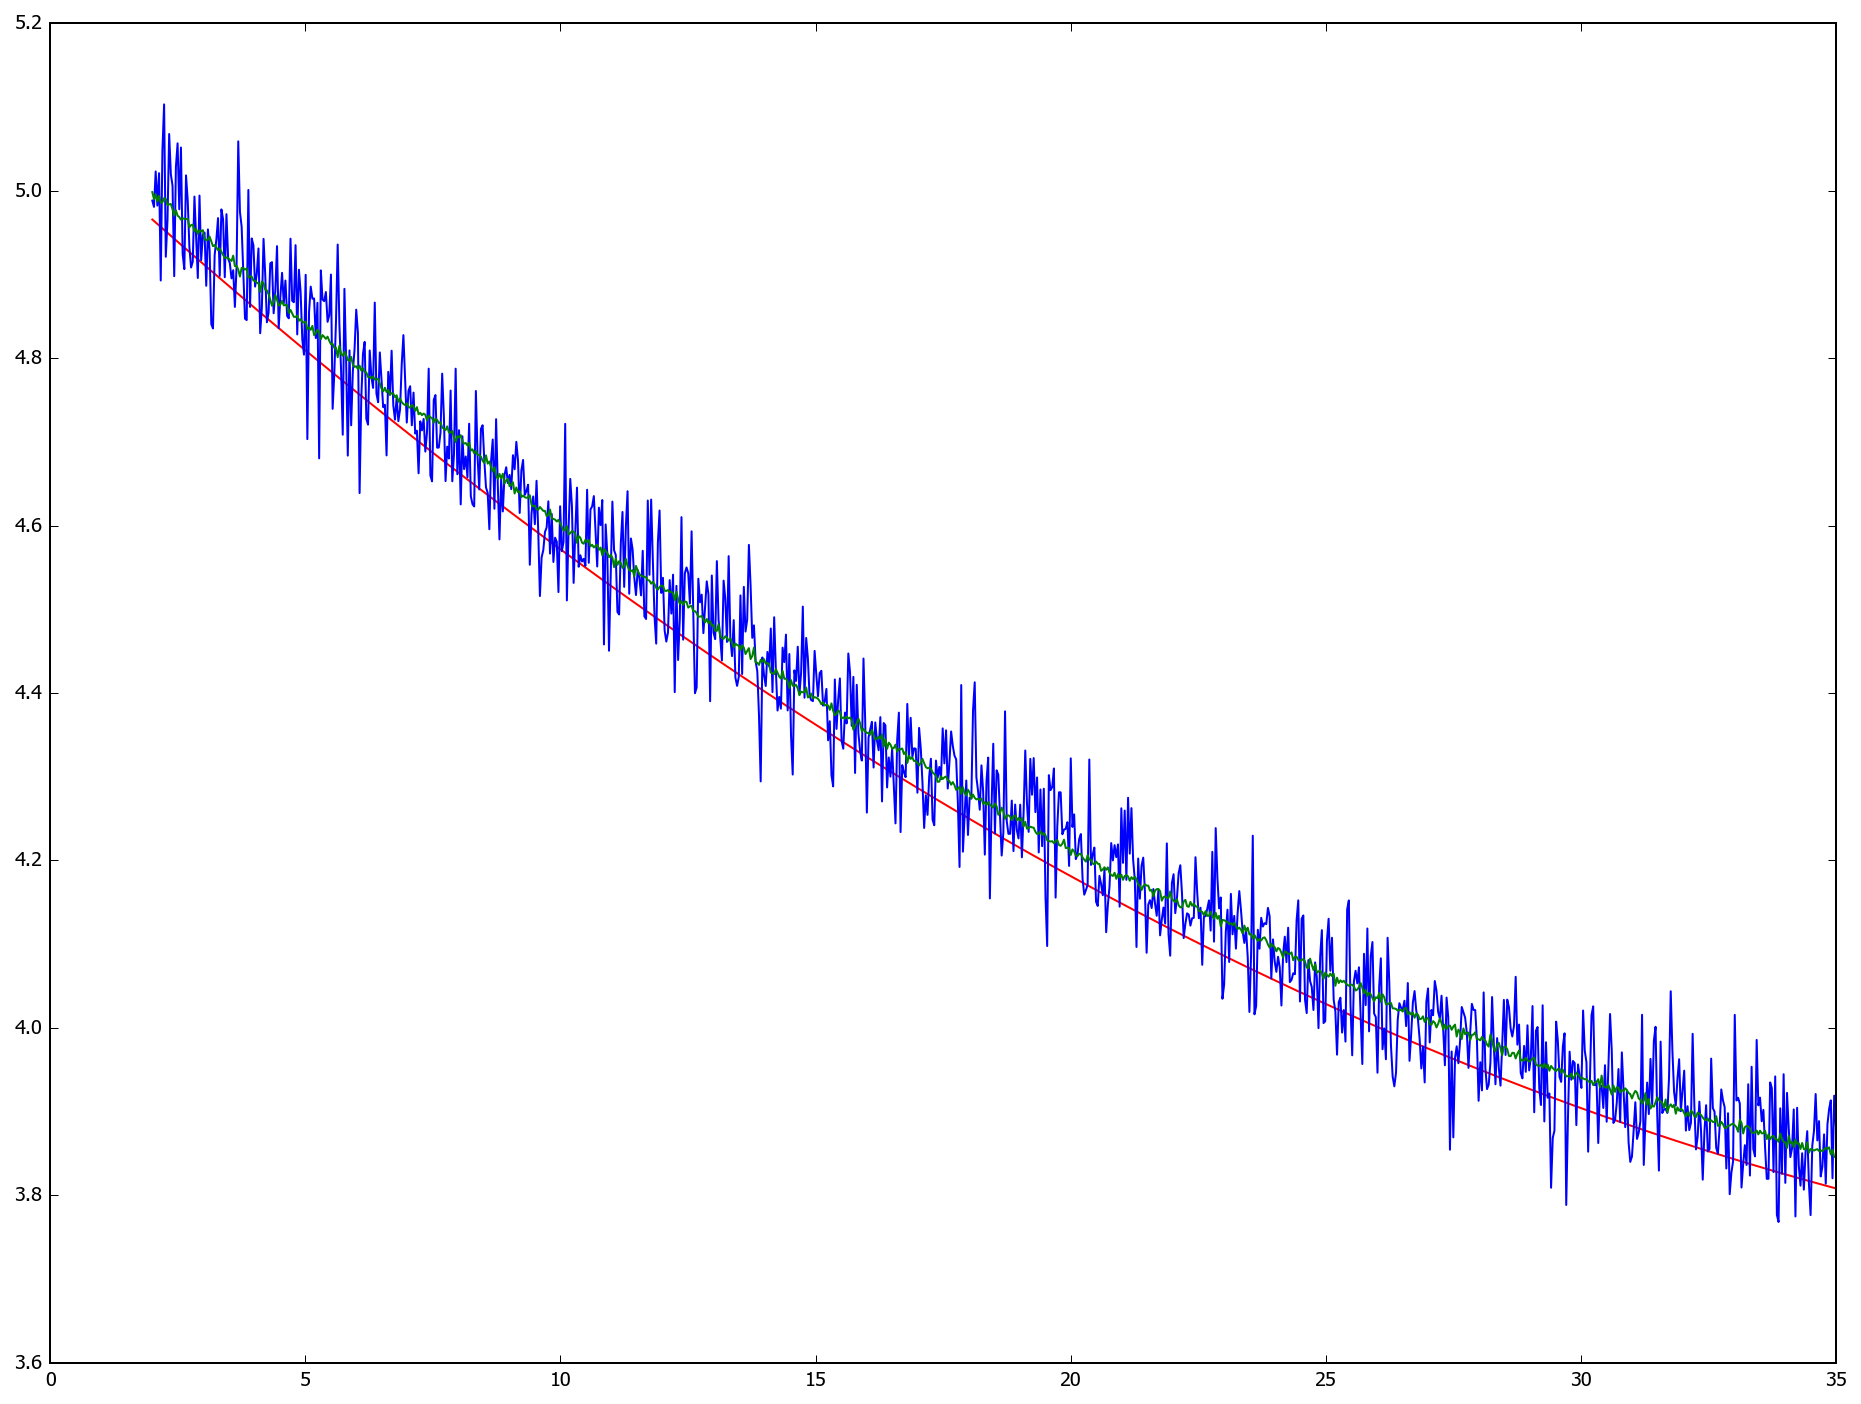

In [133]:
plt.plot(frequency_vector, np.sum(fit,0)+background_fit, 'r-')
plt.plot(frequency_vector, train_data)
plt.plot(frequency_vector, test_data)
plt.show()